# Proyek Klasifikasi Gambar: [ Animal-Faces:*wild,cat,dog* ]
- **Nama:** Akhmad Mustolih
- **Email:** akhmadmustolih371@gmail.com
- **ID Dicoding:** MC229D5Y0444

## Import dan download library yang digunakan

In [1]:
!pip install tensorflowjs

In [ ]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping
import tensorflow as tf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving animal-faces.zip to animal-faces.zip


Link dataset yang digunakan : [dataset-klasifikasi-gambar-hewan](https://www.kaggle.com/datasets/nicopalv/dataset-klasifikasi-gambar-hewan)

In [ ]:
!rm -rf /dataset-klasifikasi-gambar-hewan
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/animal-faces
!unzip animal-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

In [ ]:
# Direktori awal pada data train dan test
train_directory = 'afhq/train'
test_directory = 'afhq/val'

# Buat Direktori gabungan untuk data
combine_dir = 'afhq/combined'
os.makedirs(combine_dir, exist_ok=True)

# Salin file dari folder train
for category in os.listdir(train_directory):
  category_dir = os.path.join(train_directory, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combine_dir, category), dirs_exist_ok=True)

# Salin file dari folder testing
for category in os.listdir(test_directory):
  category_dir = os.path.join(test_directory, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combine_dir, category), dirs_exist_ok=True)

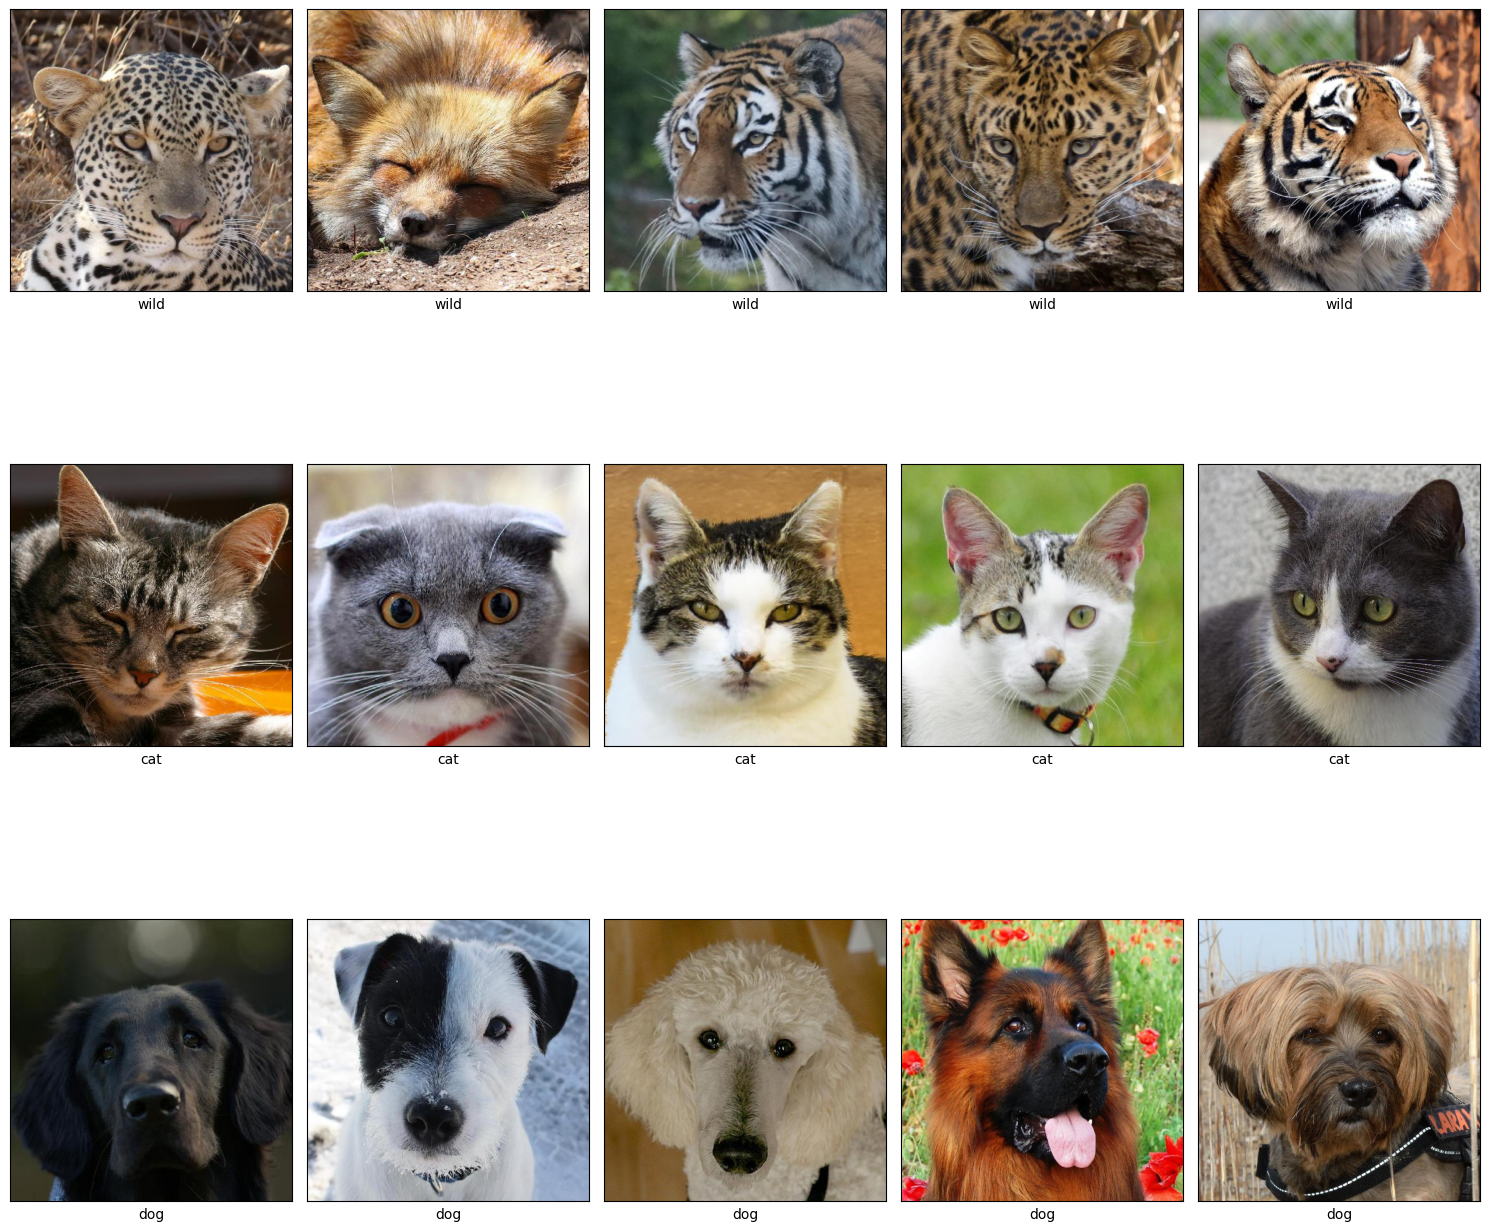

In [ ]:
from PIL import Image
lung_image = {}

# Menentukan path untuk menampilkan gambar
path = 'afhq/'
path_sub = os.path.join(path, 'combined')
for i in os.listdir(path_sub):
  lung_image[i] = os.listdir(os.path.join(path_sub, i))

path_sub = 'afhq/combined/'

# Menampilkan 5 gambar setiap kelas secara acak
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))
for i, class_name in enumerate(lung_image.keys()):
  images = np.random.choice(lung_image[class_name], 5, replace=False)
  for j, image_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, image_name)
    img = Image.open(img_path).convert('RGB')
    axs[i, j].imshow(img)
    axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

plt.tight_layout()
plt.show()

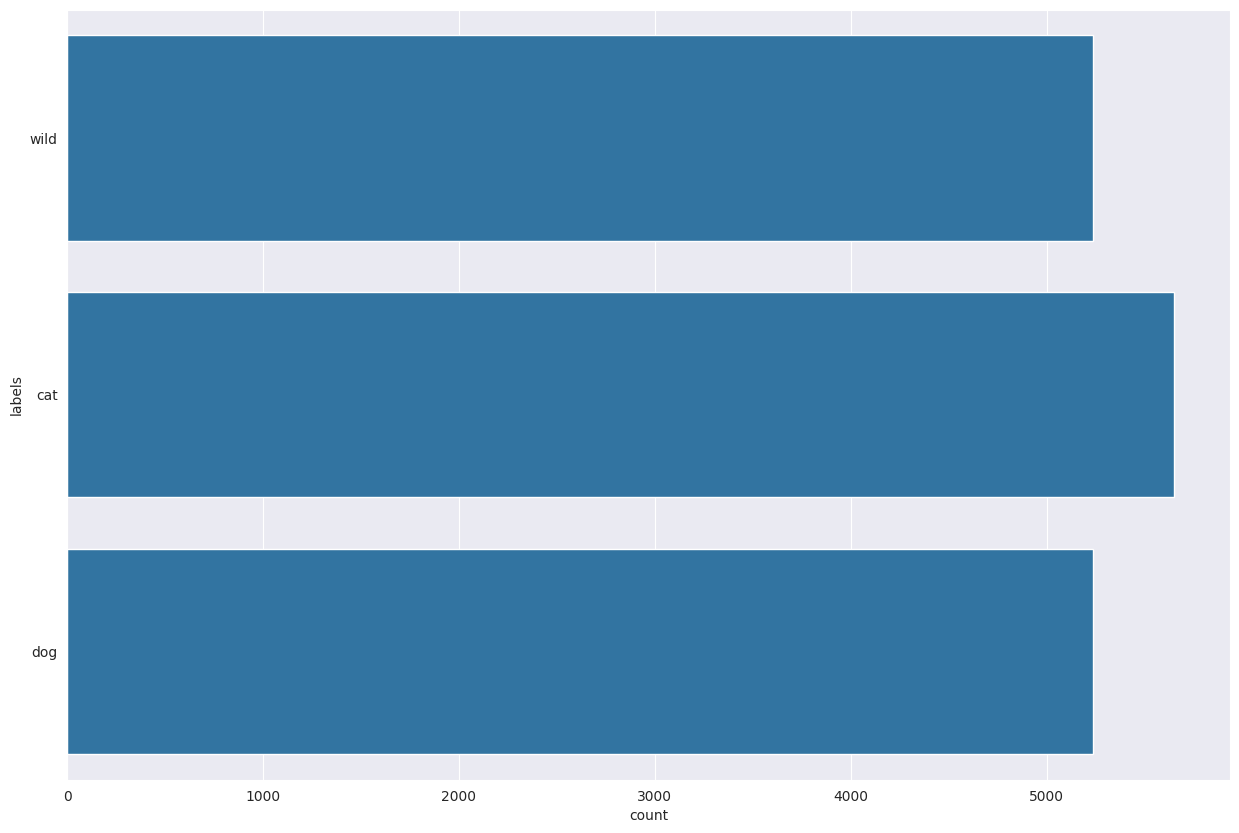

In [ ]:
lung_path = 'afhq/combined'

full_path = []
labels = []
file_name = []

for path, subdirs, files in os.walk(lung_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({'path': full_path, 'labels': labels, 'file_name': file_name})

label = distribution_train['labels']
plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')
sns.countplot(label)
plt.show()

## Data Preprocessing

### Data Check

In [ ]:
mypath = 'afhq/combined/'

full_path = []
labels = []
file_name = []

for path, subdirs, files in os.walk(mypath):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

df = pd.DataFrame({'path': full_path, 'labels': labels, 'file_name': file_name})
df.groupby('labels').size()

,0
labels,
cat,5653
dog,5239
wild,5238


Karena Jumlah datanya hampir sama mendekati satu sama lain, oleh karena itu tidak diperlukan adanya augmentasi untuk menambahkan data. Augmentasi dilakukan pada saat akan training nanti.

### Split Dataset

In [ ]:
# MPisahkan variabel
X = df['path']
y = df['labels']

# Split dataset awal menjadi data train, validation, dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set':'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set':'validation'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set':'test'})

In [ ]:
# Melihat panjang train, val, dan test
print(f'Jumlah data train: {len(df_tr)}')
print(f'Jumlah data validation: {len(df_val)}')
print(f'Jumlah data test: {len(df_test)}')

Jumlah data train: 10323
Jumlah data validation: 2581
Jumlah data test: 3226


In [ ]:
# Menggabungkan dataframe df_tr, df_val, dan df_test
df_all = pd.concat([df_tr, df_val, df_test], ignore_index=True)

display(df_all.groupby(['labels', 'set']).size(), '\n')


labels  set       
cat     test          1123
        train         3623
        validation     907
dog     test          1057
        train         3371
        validation     811
wild    test          1046
        train         3329
        validation     863
dtype: int64

'\n'

In [ ]:
# Keseluruhan data gambar
datasource_path = 'afhq/combined/'
dataset_path = 'Data-final/'

In [ ]:
for index, row in tq(df_all.iterrows()):
  file_path = row['path']
  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['labels'], row['image'].split('.')[0])

# Membuat direktori tujuan folder
  if os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels']))

# Menentukan tujuan file
  destination_file_name = file_path.split('/')[-1]
  file_dest = os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

# Copy file dari sumber ke tujuan
  if os.path.exists(file_dest) == False:
    shutil.copy2(file_path, file_dest)

0it [00:00, ?it/s]

## Modeling

In [ ]:
TRAIN_DIR = 'Data-final/train'
TEST_DIR = 'Data-final/test'
VAL_DIR = 'Data-final/validation'

train_cat = os.path.join(TRAIN_DIR + '/cat')
train_dog = os.path.join(TRAIN_DIR + '/dog')
train_wild = os.path.join(TRAIN_DIR + '/wild')

test_cat = os.path.join(TEST_DIR + '/cat')
test_dog = os.path.join(TEST_DIR + '/dog')
test_wild = os.path.join(TEST_DIR + '/wild')

val_cat = os.path.join(VAL_DIR + '/cat')
val_dog = os.path.join(VAL_DIR + '/dog')
val_wild = os.path.join(VAL_DIR + '/wild')

print('total train cat images:', len(os.listdir(train_cat)))
print('total train dog images:', len(os.listdir(train_dog)))
print('total train wild images:', len(os.listdir(train_wild)))

print('total test cat images:', len(os.listdir(test_cat)))
print('total test dog images:', len(os.listdir(test_dog)))
print('total test wild images:', len(os.listdir(test_wild)))

print('total val cat images:', len(os.listdir(val_cat)))
print('total val dog images:', len(os.listdir(val_dog)))
print('total val wild images:', len(os.listdir(val_wild)))

total train cat images: 3623
total train dog images: 3371
total train wild images: 3329
total test cat images: 1123
total test dog images: 1057
total test wild images: 1046
total val cat images: 907
total val dog images: 811
total val wild images: 863


### Image Generator

In [ ]:
# Melakukan sedikit augmentasi gambar
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    batch_size=32,
                                                    target_size=(224, 224),
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)
validation_generator = val_datagen.flow_from_directory(VAL_DIR,
                                                      batch_size=32,
                                                      target_size=(224, 224),
                                                      class_mode='categorical',
                                                      shuffle=True)
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=32,
                                                  target_size=(224, 224),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 10323 images belonging to 3 classes.
Found 2581 images belonging to 3 classes.
Found 3226 images belonging to 3 classes.


### Model

In [ ]:
# Membuat model
model = Sequential()

# Penggunaan transfer learning DenseNet121
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze weights

model.add(base_model)

# Tambahan Conv2D setelah MobileNetV2
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Fully connected
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

# Callback
class CustomStopByAccuracyLoss(Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("acc") or logs.get("accuracy")
        loss = logs.get("loss")
        if acc is not None and loss is not None:
            if acc >= 0.95 and loss <= 0.05:
                print(f"\nTraining berhenti karena accuracy sudah mencapai >= 95% dan loss <= 0.05")
                self.model.stop_training = True

callbacks_list = [
    CustomStopByAccuracyLoss(),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,128,451 (15.75 MB)

 Trainable params: 1,869,699 (7.13 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [ ]:
count_cat, count_wild, count_dog = len(os.listdir(train_cat)), len(os.listdir(train_wild)), len(os.listdir(train_dog))
weight_0 = (1 / count_cat) * (count_cat + count_wild + count_dog) / 3.0
weight_1 = (1 / count_wild) * (count_cat + count_wild + count_dog) / 3.0
weight_2 = (1 / count_dog) * (count_cat + count_wild + count_dog) / 3.0

class_weight = {0: weight_0, 1: weight_1, 2: weight_2}

# Fitting model/ training model
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,
                    validation_data=validation_generator,
                    class_weight=class_weight,
                    callbacks=callbacks_list)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 177s 501ms/step - accuracy: 0.8895 - loss: 0.3145 - val_accuracy: 0.9950 - val_loss: 0.0154
Epoch 2/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9914 - loss: 0.0325
Training berhenti karena accuracy sudah mencapai >= 95% dan loss <= 0.05
323/323 ━━━━━━━━━━━━━━━━━━━━ 147s 456ms/step - accuracy: 0.9914 - loss: 0.0325 - val_accuracy: 0.9961 - val_loss: 0.0177


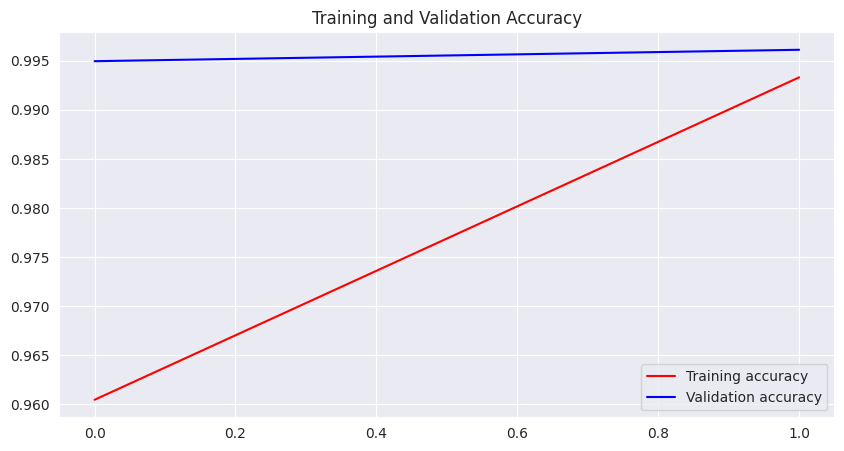

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='blue')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

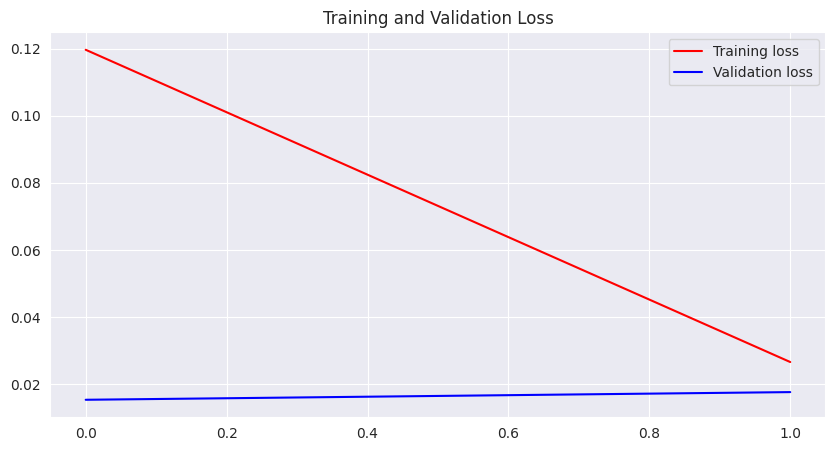

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training loss', color='red')
plt.plot(history.history['val_loss'], label='Validation loss', color='blue')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step


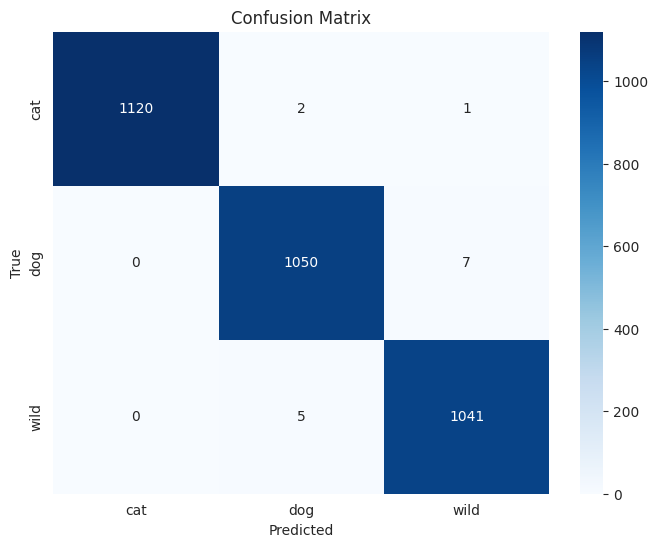

              precision    recall  f1-score   support

         cat       1.00      1.00      1.00      1123
         dog       0.99      0.99      0.99      1057
        wild       0.99      1.00      0.99      1046

    accuracy                           1.00      3226
   macro avg       1.00      1.00      1.00      3226
weighted avg       1.00      1.00      1.00      3226



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


## Konversi Model

In [ ]:
# Save model .h5
os.makedirs('submission/saved_model', exist_ok=True)
model.export('submission/saved_model')

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137987833926032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137987833923920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137987837707472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137987833924688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137987833925840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137987833926224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137987837707088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137987837708048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137987837708432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137987837708240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1379

In [ ]:
# tfjs_model
os.makedirs('submission/tfjs_model', exist_ok=True)
tfjs.converters.save_keras_model(model, 'submission/tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
# tflite
os.makedirs('submission/tflite', exist_ok=True)
converter = tf.lite.TFLiteConverter.from_saved_model('submission/saved_model')
tflite_model = converter.convert()
with open('submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# 4. Save label.txt
labels = list(test_generator.class_indices.keys())
with open('submission/tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

## Inferensi


Saving kucing.webp to kucing.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
kucing.webp
Prediction: cat


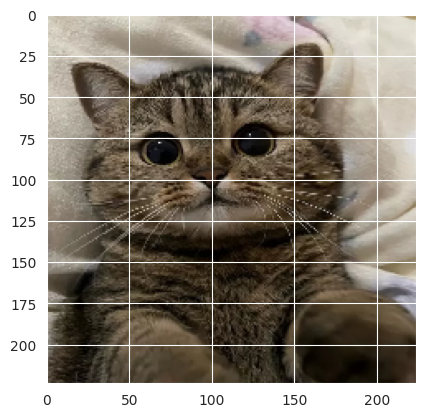

In [ ]:
def upload_predict_and_display(model):

 # Upload gambar
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():

    # prediksi gambar
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)

    print(fn)
    predicted_class_index = np.argmax(classes)
    class_labels = list(train_generator.class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index]

    print(f"Prediction: {predicted_class_label}")

upload_predict_and_display(model)